In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from scipy.stats import ttest_ind

In [2]:
df = pd.read_excel("QVI_transaction_data.xlsx", na_values=["na", "NA", "null", " ", ""])

- Figure out data

In [3]:
print(df.shape)

(264836, 8)


In [4]:
print(df.columns)

Index(['DATE', 'STORE_NBR', 'LYLTY_CARD_NBR', 'TXN_ID', 'PROD_NBR',
       'PROD_NAME', 'PROD_QTY', 'TOT_SALES'],
      dtype='object')


- Check Missing values ​​and outliers

In [5]:
print(df.isnull().sum())

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64


In [6]:
print(df.describe())

                DATE     STORE_NBR  LYLTY_CARD_NBR        TXN_ID  \
count  264836.000000  264836.00000    2.648360e+05  2.648360e+05   
mean    43464.036260     135.08011    1.355495e+05  1.351583e+05   
std       105.389282      76.78418    8.057998e+04  7.813303e+04   
min     43282.000000       1.00000    1.000000e+03  1.000000e+00   
25%     43373.000000      70.00000    7.002100e+04  6.760150e+04   
50%     43464.000000     130.00000    1.303575e+05  1.351375e+05   
75%     43555.000000     203.00000    2.030942e+05  2.027012e+05   
max     43646.000000     272.00000    2.373711e+06  2.415841e+06   

            PROD_NBR       PROD_QTY      TOT_SALES  
count  264836.000000  264836.000000  264836.000000  
mean       56.583157       1.907309       7.304200  
std        32.826638       0.643654       3.083226  
min         1.000000       1.000000       1.500000  
25%        28.000000       2.000000       5.400000  
50%        56.000000       2.000000       7.400000  
75%        85.00

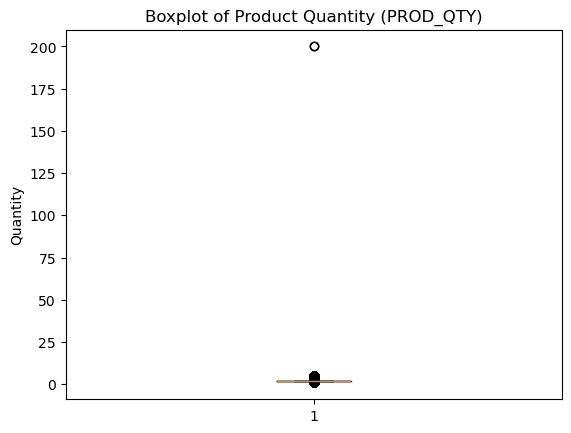

In [7]:
plt.boxplot(df['PROD_QTY'])
plt.title("Boxplot of Product Quantity (PROD_QTY)")
plt.ylabel("Quantity")
plt.show()

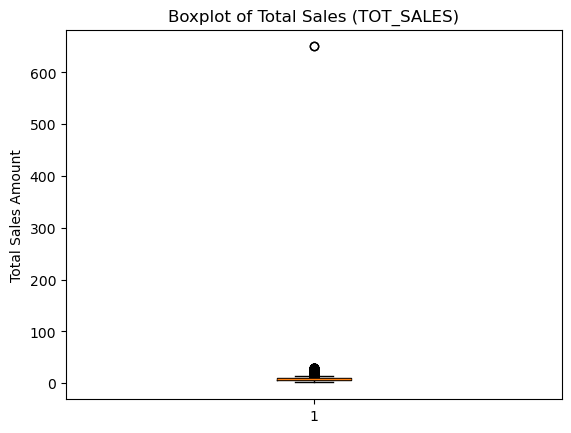

In [8]:
plt.boxplot(df['TOT_SALES'])
plt.title("Boxplot of Total Sales (TOT_SALES)")
plt.ylabel("Total Sales Amount")
plt.show()

- Remove Outlier

In [9]:
Q1_P = df['PROD_QTY'].quantile(0.25)
Q3_P = df['PROD_QTY'].quantile(0.75)
Q1_T = df['TOT_SALES'].quantile(0.25)
Q3_T = df['TOT_SALES'].quantile(0.75)
IQR_P = Q3_P - Q1_P
IQR_T = Q3_T - Q1_T
lower_P = Q1_P - 1.5 * IQR_P
upper_P = Q3_P + 1.5 * IQR_P
lower_T = Q1_T - 1.5 * IQR_T
upper_T = Q3_T + 1.5 * IQR_T
df_clean = df[
            (df['TOT_SALES'] >= lower_T) & (df['TOT_SALES'] <= upper_T)&
            (df['PROD_QTY'] >= lower_P) & (df['PROD_QTY'] <= upper_P)
            ]

In [10]:
print(f"Final number of clean records: {len(df_clean)}")

Final number of clean records: 236039


In [11]:
print(df.dtypes)

DATE                int64
STORE_NBR           int64
LYLTY_CARD_NBR      int64
TXN_ID              int64
PROD_NBR            int64
PROD_NAME          object
PROD_QTY            int64
TOT_SALES         float64
dtype: object


In [12]:
df['DATE'] = pd.to_datetime(df['DATE'])

- Sperate to Brand and gram

In [13]:
df['BRAND'] = df['PROD_NAME'].str.split().str[0]

In [14]:
brand_count = df['BRAND'].value_counts()
print(brand_count)

BRAND
Kettle        41288
Smiths        28860
Pringles      25102
Doritos       24962
Thins         14075
RRD           11894
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Old            9324
Tyrrells       6442
Grain          6272
Natural        6050
Red            5885
Cheezels       4603
CCs            4551
Woolworths     4437
Dorito         3185
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: count, dtype: int64


In [15]:
brands = df['BRAND'].unique()
smilar_brand = []
for i,brand in enumerate(brands):
    for other in brands[i+1:]:
        score=fuzz.ratio(brand,other)
        if score>=85 and brand != other:
            smilar_brand.append((brand,other,score))
for b1,b2,s in sorted(smilar_brand, key=lambda x: -x[2]):
    print(f"{b1} ↔ {b2} (smilarity: {s})")

Doritos ↔ Dorito (smilarity: 92)
Smiths ↔ Smith (smilarity: 91)


In [16]:
brand_fix_map = {
    'Smith': 'Smiths',
    'Red': 'RRD',
    'WOOLWORTHS': 'Woolworths',
    'WW': 'Woolworths',
    'SNBTS': 'SunBites',
    'Infzns': 'Infuzions',
    'NCC': 'Natural',
    'Dorito': 'Doritos',
    'Grain': 'GrnWves',
    'Snbts':'Sunbites',
    'NATURAL':'Natural'
}

df['BRAND'] = df['BRAND'].replace(brand_fix_map)

In [17]:
import re
df['PACK_SIZE'] = df['PROD_NAME'].str.extract(r'(\d+)\s*[gG]', expand=False)
df['PACK_SIZE'] = df['PACK_SIZE'].astype(float)

In [18]:
print(df[['PROD_NAME', 'BRAND', 'PACK_SIZE']].head(10))

                                  PROD_NAME    BRAND  PACK_SIZE
0    Natural Chip        Compny SeaSalt175g  Natural      175.0
1                  CCs Nacho Cheese    175g      CCs      175.0
2    Smiths Crinkle Cut  Chips Chicken 170g   Smiths      170.0
3    Smiths Chip Thinly  S/Cream&Onion 175g   Smiths      175.0
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g   Kettle      150.0
5  Old El Paso Salsa   Dip Tomato Mild 300g      Old      300.0
6  Smiths Crinkle Chips Salt & Vinegar 330g   Smiths      330.0
7     Grain Waves         Sweet Chilli 210g  GrnWves      210.0
8   Doritos Corn Chip Mexican Jalapeno 150g  Doritos      150.0
9     Grain Waves Sour    Cream&Chives 210G  GrnWves      210.0


In [19]:
print(df['PACK_SIZE'].isnull().sum())

0


In [20]:
df_cust = pd.read_excel("QVI_purchase_behaviour.xlsx")

In [21]:
df_merged = pd.merge(df, df_cust, on='LYLTY_CARD_NBR')

In [22]:
sales = df_merged.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()
print(sales.head())

                LIFESTAGE PREMIUM_CUSTOMER  TOT_SALES
0  MIDAGE SINGLES/COUPLES           Budget   35514.80
1  MIDAGE SINGLES/COUPLES       Mainstream   90803.85
2  MIDAGE SINGLES/COUPLES          Premium   58432.65
3            NEW FAMILIES           Budget   21928.45
4            NEW FAMILIES       Mainstream   17013.90


In [23]:
cust_count = df_merged.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index()
print(cust_count.head())

                LIFESTAGE PREMIUM_CUSTOMER  LYLTY_CARD_NBR
0  MIDAGE SINGLES/COUPLES           Budget            1504
1  MIDAGE SINGLES/COUPLES       Mainstream            3340
2  MIDAGE SINGLES/COUPLES          Premium            2431
3            NEW FAMILIES           Budget            1112
4            NEW FAMILIES       Mainstream             849


In [24]:
avg_qty = df_merged.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].mean().reset_index()
print(avg_qty.head())

                LIFESTAGE PREMIUM_CUSTOMER  PROD_QTY
0  MIDAGE SINGLES/COUPLES           Budget  1.891633
1  MIDAGE SINGLES/COUPLES       Mainstream  1.911656
2  MIDAGE SINGLES/COUPLES          Premium  1.889727
3            NEW FAMILIES           Budget  1.853910
4            NEW FAMILIES       Mainstream  1.857634


In [25]:
avg_price = df_merged.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum() / df_merged.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].sum()
avg_price = avg_price.reset_index(name='AVG_PRICE')
print(avg_price.head())

                LIFESTAGE PREMIUM_CUSTOMER  AVG_PRICE
0  MIDAGE SINGLES/COUPLES           Budget   3.739975
1  MIDAGE SINGLES/COUPLES       Mainstream   4.000346
2  MIDAGE SINGLES/COUPLES          Premium   3.763535
3            NEW FAMILIES           Budget   3.936178
4            NEW FAMILIES       Mainstream   3.939315


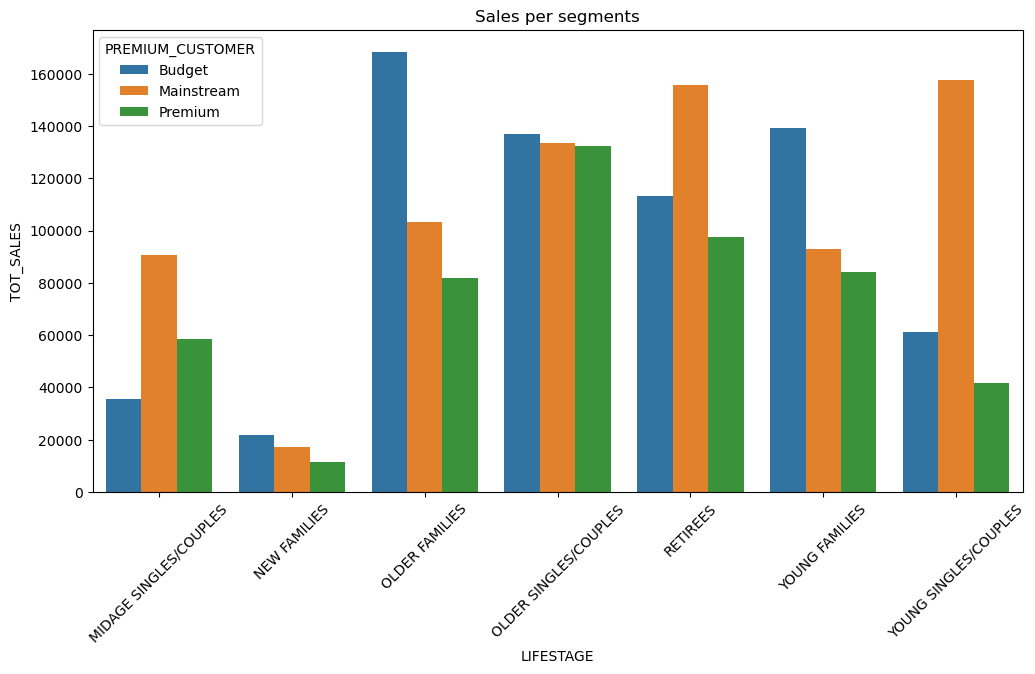

In [26]:
plt.figure(figsize=(12, 6))
sns.barplot(data=sales, x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER')
plt.xticks(rotation=45)
plt.title('Sales per segments')
plt.show()

- The Premium group shows lower total spending across all segments, except for one.
- The Older Singles/Couples group demonstrates consistently high spending across all customer types.
- Within the Young Singles/Couples group, the Mainstream segment spends significantly more than the other two segments.
- The New Families group shows very low spending across all customer segments.

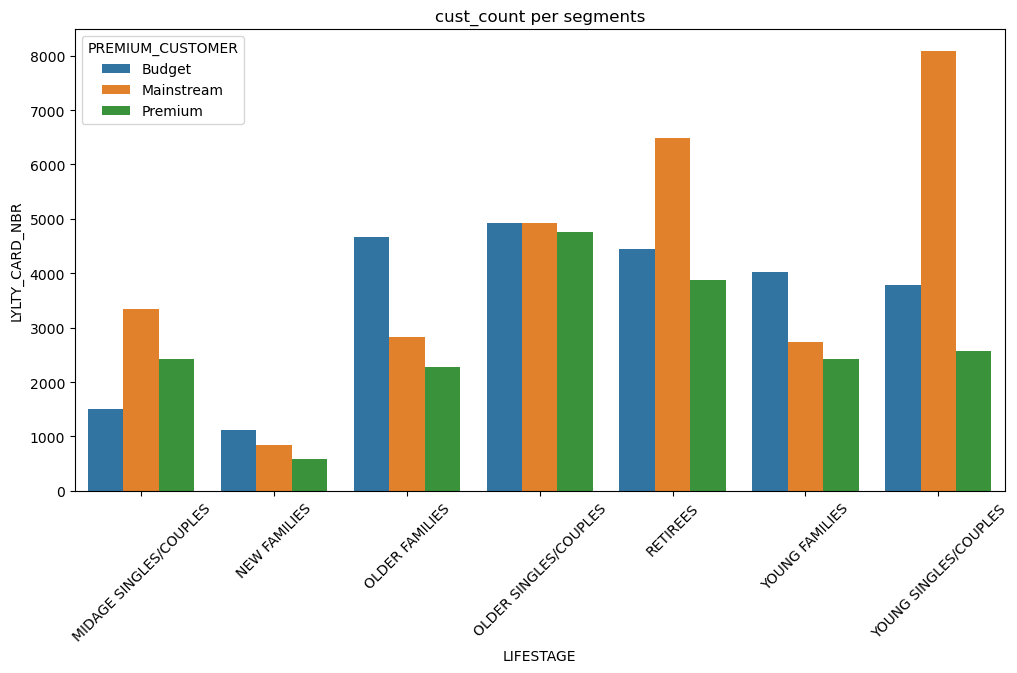

In [27]:
plt.figure(figsize=(12, 6))
sns.barplot(data=cust_count, x='LIFESTAGE', y='LYLTY_CARD_NBR', hue='PREMIUM_CUSTOMER')
plt.xticks(rotation=45)
plt.title('cust_count per segments')
plt.show()

- The Young Singles/Couples – Mainstream segment has the largest number of customers among all segments.
- In general, the Premium segment has the smallest customer base overall.
- The Older Families – Budget segment, despite having fewer customers, contributes a high amount to total sales, indicating high purchasing power.
- The New Families segment has a small number of customers across all customer types.

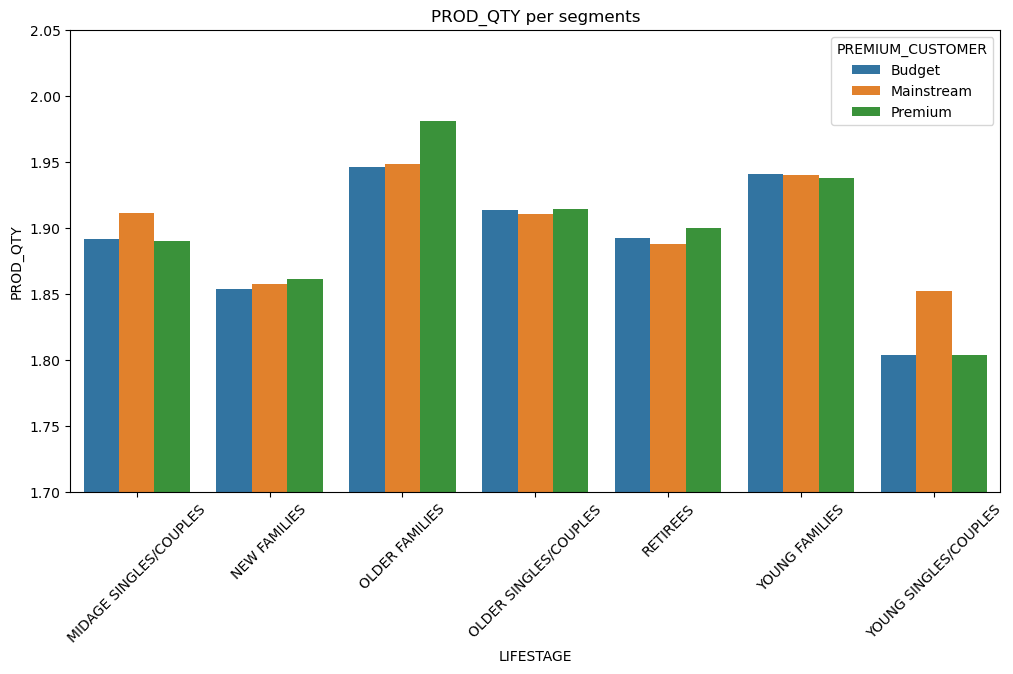

In [28]:
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_qty, x='LIFESTAGE', y='PROD_QTY', hue='PREMIUM_CUSTOMER')
plt.xticks(rotation=45)
plt.ylim(1.7, 2.05)
plt.title('PROD_QTY per segments')
plt.show()

- The Older Families – Premium group buys around two units per transaction on average.
- The Young Singles/Couples group buys the fewest chips on average across all segments.

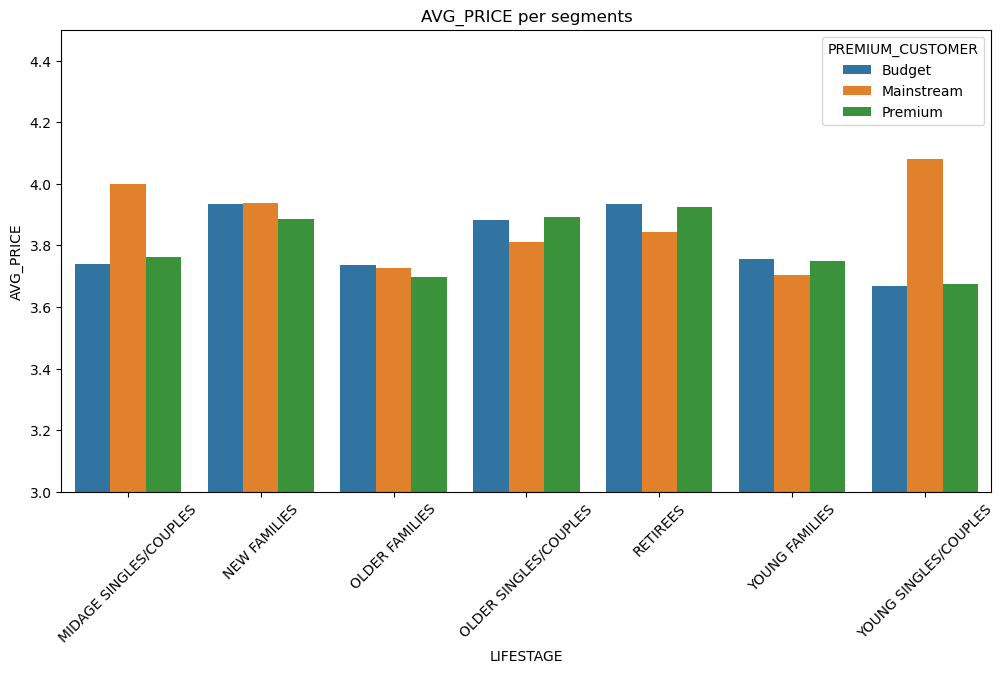

In [29]:
plt.figure(figsize=(12, 6))
sns.barplot(data= avg_price, x='LIFESTAGE', y='AVG_PRICE', hue='PREMIUM_CUSTOMER')
plt.xticks(rotation=45)
plt.ylim(3.0, 4.5)
plt.title('AVG_PRICE per segments')
plt.show()

- The Young Singles/Couples – Mainstream segment pays the highest average price per pack.
- The Older Families – Premium group buys in higher quantity but prefers lower-priced products.

# Brand preference per Segment

In [30]:
# The highest segment in avg_price
segment = df_merged[(df_merged['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')&
             (df_merged['PREMIUM_CUSTOMER'] == 'Mainstream')]
other = df_merged[~((df_merged['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')&
             (df_merged['PREMIUM_CUSTOMER'] == 'Mainstream'))]

In [31]:
seg_brand = segment.groupby('BRAND')['PROD_QTY'].sum()/segment['PROD_QTY'].sum()
other_brand=other.groupby('BRAND')['PROD_QTY'].sum()/other['PROD_QTY'].sum()

In [32]:
affinity = (seg_brand / other_brand).sort_values(ascending=False)
print(affinity)

BRAND
Tyrrells      1.237296
Twisties      1.228454
Kettle        1.204856
Tostitos      1.204671
Old           1.197985
Pringles      1.195561
Doritos       1.158732
Cobs          1.151688
Infuzions     1.141926
Thins         1.067360
GrnWves       1.056731
Cheezels      0.970974
Smiths        0.768194
French        0.690706
Cheetos       0.670721
RRD           0.663718
Natural       0.640000
CCs           0.596110
Sunbites      0.508479
Woolworths    0.491276
Burger        0.446920
Name: PROD_QTY, dtype: float64


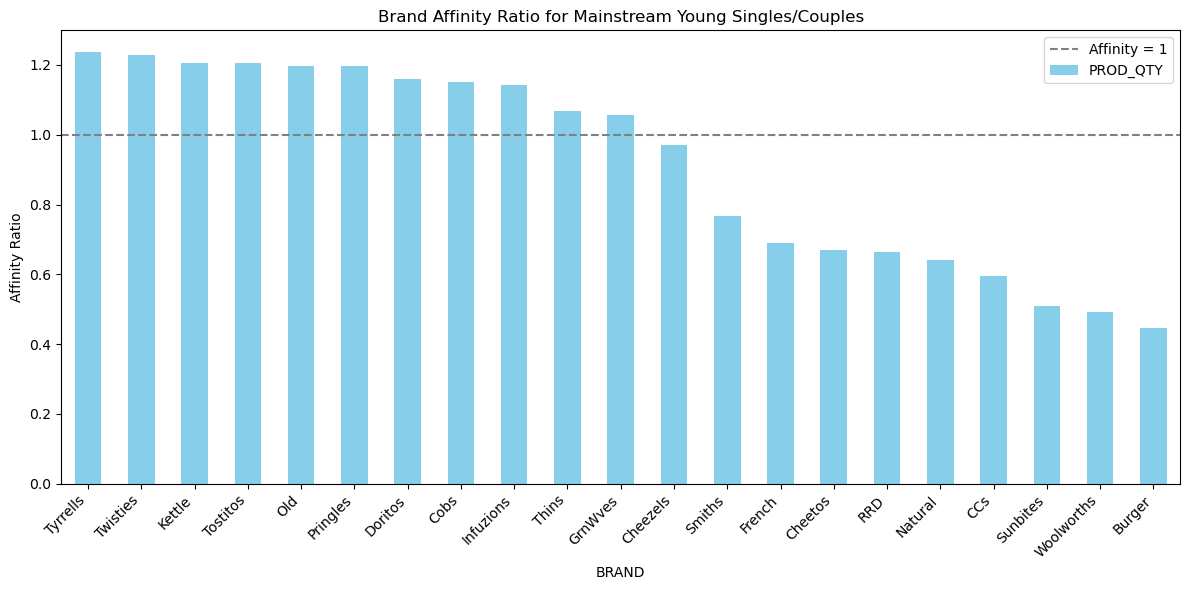

In [34]:
plt.figure(figsize=(12, 6))
affinity.plot(kind='bar', color='skyblue')
plt.axhline(y=1, color='gray', linestyle='--', label='Affinity = 1')
plt.title("Brand Affinity Ratio for Mainstream Young Singles/Couples")
plt.ylabel("Affinity Ratio")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


# Test

In [ ]:
df_merged['price_per_unit'] = df_merged['TOT_SALES'] / df_merged['PROD_QTY']

In [ ]:
mainstream_group = df_merged[
    (df_merged['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES'])) &
    (df_merged['PREMIUM_CUSTOMER'] == 'Mainstream')
]['price_per_unit']

In [ ]:
other_group = df_merged[
    (df_merged['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES'])) &
    (df_merged['PREMIUM_CUSTOMER'] != 'Mainstream')
]['price_per_unit']

In [ ]:
t_stat, p_val = ttest_ind(mainstream_group, other_group, equal_var=False)

In [ ]:
print(f"Tstatis: {t_stat:.2f}, pvalue: {p_val:.5f}")

t-statistic has large value and P-value < 0.05, it means this is meaningful result.